In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn
from tqdm import tqdm

import random

In [14]:
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [15]:
N = 500 # Размер датасета

X = np.random.random((N, 2)) * 4 - 2 # N пар значений от (-2, +2)

Y = X[:, 0] * X[:, 1] * 1.5 # Формируем седловую функцию, эта функция в реальной жизни нам неизвестна

# X    - входные данные
# Y    - целевая переменная
# Ypred - предсказанное значение

X = torch.from_numpy(X).to(torch.float64)
Y = torch.from_numpy(Y).to(torch.float64)

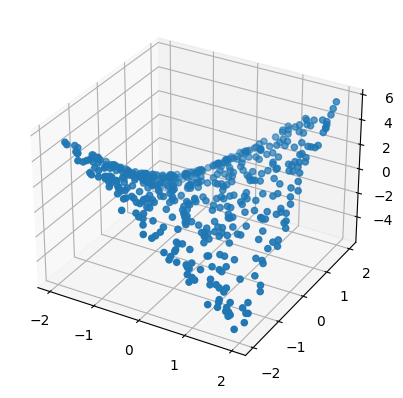

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Y)
plt.show()

In [17]:
D = 2 # Размер входа
M = 10 # Количество скрытых нейронов

In [18]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(D, M, dtype=torch.float64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(M, 1, dtype=torch.float64)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Using cpu device


# SGD, Adam, RMSprop from scratch optimizers implementation

In [55]:
class SGD(torch.optim.Optimizer):
    def __init__(self,
                 params,
                 lr=0.001, momentum=0, dampening=0, nesterov=False):
        # Check if lr and momentum are invalid (negative)
        if lr < 0:
            raise ValueError(f"Invalid learning rate: {lr}")
            
        if momentum < 0.0:
            raise ValueError(f"Invalid momentum value: {momentum}")
            
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        
        DEFAULTS = dict(lr=lr, momentum=momentum, dampening=dampening, nesterov=nesterov)
        
        super(SGD, self).__init__(params, DEFAULTS)
    
    
    def step(self, closure=None):
        loss = None
        
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        
        if not self.state["step"]:
            self.state["step"] = 1
        else: self.state["step"] += 1
            
        # Iterate over "groups" of parameters (layers of parameters in the network)
        for param_group in self.param_groups:
            # Iterate over individual parameters
            for param_index, param in enumerate(param_group["params"]):
                
                if param.grad.data == None:
                    continue
                else: gradients = param.grad.data
                
                if self.state["step"] == 1:
                    self.state[f"momentum_buffer_{param_index}"] = torch.zeros_like(param.data)
                
                if param_group['momentum'] != 0:
                    momentum_buffer = self.state[f"momentum_buffer_{param_index}"]
                    
                    if self.state['step'] > 1:
                        momentum_buffer.mul_(param_group['momentum']).add_(gradients * (1 - param_group['dampening']))
                    else:
                        momentum_buffer = torch.clone(gradients).detach()
                        
                    if param_group['nesterov']:
                        gradients.add_(momentum_buffer * param_group['momentum'])
                    else:
                        gradients = momentum_buffer
                        
                param.data.sub_(param_group["lr"] * gradients)
                
        return loss

In [56]:
class Adam(torch.optim.Optimizer):
    def __init__(self, 
                 params, lr=0.001, bias_m1=0.9, bias_m2=0.999, epsilon=10e-8, bias_correction=True):
        # Check if stepsizes and biases are invalid (negative)
        if lr < 0:
            raise ValueError(f"Invalid learning rate: {lr}")
        
        if (not 0 <= bias_m1 < 1 or not 0 <= bias_m2 < 1) and bias_correction:
            raise ValueError(f"Invalid bias parameters: {bias_m1=}, {bias_m2=}")
            
        if epsilon < 0:
            raise ValueError(f"Invalid epsilon value: {epsilon}")
        
        DEFAULTS = dict(lr=lr, bias_m1=bias_m1, bias_m2=bias_m2, epsilon=epsilon, bias_correction=bias_correction)
        
        super(Adam, self).__init__(params, DEFAULTS)
        
    
    def step(self, closure=None):
        loss = None
        
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        
        if not self.state["step"]:
            self.state["step"] = 1
        else: self.state["step"] += 1
            
        # Iterate over "groups" of parameters (layers of parameters in the network)
        for param_group in self.param_groups:
            # Iterate over individual parameters
            for param_index, param in enumerate(param_group["params"]):
                
                if param.grad.data == None:
                    continue
                else: gradients = param.grad.data
                
                if self.state["step"] == 1:
                    self.state[f"first_moment_{param_index}"] = torch.zeros_like(param.data)
                    self.state[f"second_moment_{param_index}"] = torch.zeros_like(param.data)
                
                first_moment = self.state[f"first_moment_{param_index}"]
                second_moment = self.state[f"second_moment_{param_index}"]
                
                first_moment.mul_(param_group["bias_m1"]).add_(gradients * (1.0 - param_group["bias_m1"]))
                
                second_moment.mul_(param_group["bias_m2"]).add_(gradients.pow(2) * (1.0 - param_group["bias_m2"]))
            
                if param_group["bias_correction"]:
                    first_moment_temp = first_moment.divide(1.0 - (param_group["bias_m1"] ** self.state["step"]))
                    
                    second_moment_temp = second_moment.divide(1.0 - (param_group["bias_m2"] ** self.state["step"]))
                    
                param.data.sub_(param_group["lr"] * first_moment_temp.divide(second_moment_temp.sqrt() + param_group["epsilon"]))

        return loss

In [68]:
class RMSprop(torch.optim.Optimizer):
    def __init__(self, 
                 params, lr=0.01, alpha=0.99, epsilon=1e-8):
        if lr < 0:
            raise ValueError(f"Invalid learning rate: {lr}")
        
        if alpha < 0:
            raise ValueError(f"Invalid alpha parameter: {alpha}")
            
        if epsilon < 0:
            raise ValueError(f"Invalid epsilon value: {epsilon}")
        
        DEFAULTS = dict(lr=lr, alpha=alpha, epsilon=epsilon)
        
        super(RMSprop, self).__init__(params, DEFAULTS)
        
    
    def step(self, closure=None):
        loss = None
        
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        
        if not self.state["step"]:
            self.state["step"] = 1
        else: self.state["step"] += 1
            
        # Iterate over "groups" of parameters (layers of parameters in the network)
        for param_group in self.param_groups:
            # Iterate over individual parameters
            for param_index, param in enumerate(param_group["params"]):
                
                if param.grad.data == None:
                    continue    
                else: gradients = param.grad.data
                
                if self.state["step"] == 1:
                    self.state[f"square_average_{param_index}"] = torch.zeros_like(param.data)

                square_average = self.state[f"square_average_{param_index}"]
                
                square_average.mul_(param_group["alpha"]).add_(gradients.pow(2) * (1.0 - param_group["alpha"]))
        
                param.data.sub_(param_group["lr"] * gradients.divide(square_average.sqrt() + param_group["epsilon"]))
        
        return loss

# StepLR, ExponentialLR from scratch shedulers implementation

In [72]:
class StepLR(torch.optim.lr_scheduler.LRScheduler):
    """Decays the learning rate of each parameter group by gamma every
    step_size epochs. Notice that such decay can happen simultaneously with
    other changes to the learning rate from outside this scheduler. When
    last_epoch=-1, sets initial lr as lr.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        step_size (int): Period of learning rate decay.
        gamma (float): Multiplicative factor of learning rate decay.
            Default: 0.1.
        last_epoch (int): The index of last epoch. Default: -1.

    Example:
        >>> # xdoctest: +SKIP
        >>> # Assuming optimizer uses lr = 0.05 for all groups
        >>> # lr = 0.05     if epoch < 30
        >>> # lr = 0.005    if 30 <= epoch < 60
        >>> # lr = 0.0005   if 60 <= epoch < 90
        >>> # ...
        >>> scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
        >>> for epoch in range(100):
        >>>     train(...)
        >>>     validate(...)
        >>>     scheduler.step()
    """

    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        step_size: int,
        gamma=0.1,
        last_epoch=-1
    ):
        self.step_size = step_size
        self.gamma = gamma
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if (self.last_epoch == 0) or (self.last_epoch % self.step_size != 0):
            return [group["lr"] for group in self.optimizer.param_groups]
        
        return [group["lr"] * self.gamma for group in self.optimizer.param_groups]

In [77]:
class ExponentialLR(torch.optim.lr_scheduler.LRScheduler):
    """Decays the learning rate of each parameter group by gamma every epoch.
    When last_epoch=-1, sets initial lr as lr.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        gamma (float): Multiplicative factor of learning rate decay.
        last_epoch (int): The index of last epoch. Default: -1.
    """

    def __init__(
        self, optimizer: torch.optim.Optimizer, 
        gamma: float, 
        last_epoch=-1
    ):
        self.gamma = gamma
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch == 0:
            return [group["lr"] for group in self.optimizer.param_groups]
        
        return [group["lr"] * self.gamma for group in self.optimizer.param_groups]

In [118]:
def train_loop(net, loss_fn, optimizer, scheduler=None, num_epochs=10, learning_rate=5e-3):
    losses = []
    lrs = []
  
    for epoch in tqdm(range(num_epochs)):
        Ypred = net.forward(X)
    
        loss = loss_fn(Ypred, Y[:, None])
        losses.append(loss.item())
    
        if epoch % 1000 == 0:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(X.detach().numpy()[:,0], 
                       X.detach().numpy()[:,1], 
                       Ypred.detach().numpy())
            plt.title(f"Loss:{loss.item()}")
            plt.show()

        loss.backward()

        optimizer.step()
        
        lrs.append(scheduler.get_lr()[0])
        if scheduler is not None: scheduler.step()

        optimizer.zero_grad()

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(lrs)
    plt.xlabel('Epoch')
    plt.ylabel('Learning rate')
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

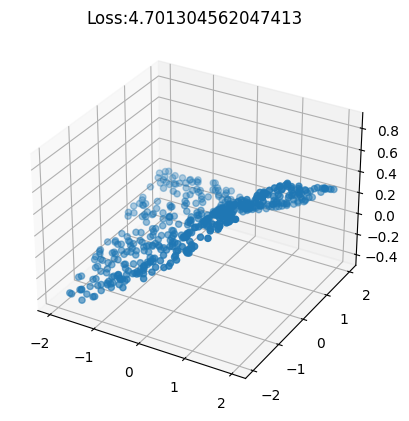

100%|██████████| 1000/1000 [00:01<00:00, 834.27it/s]


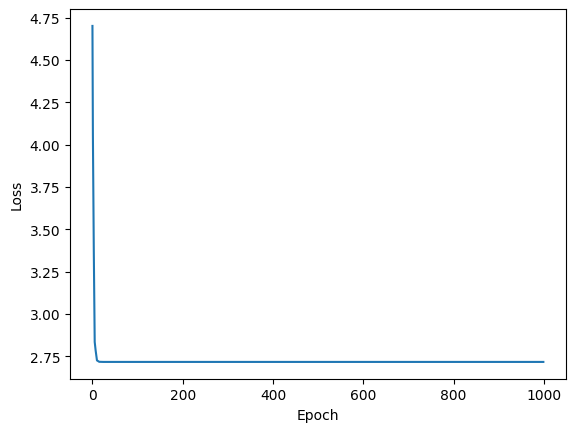

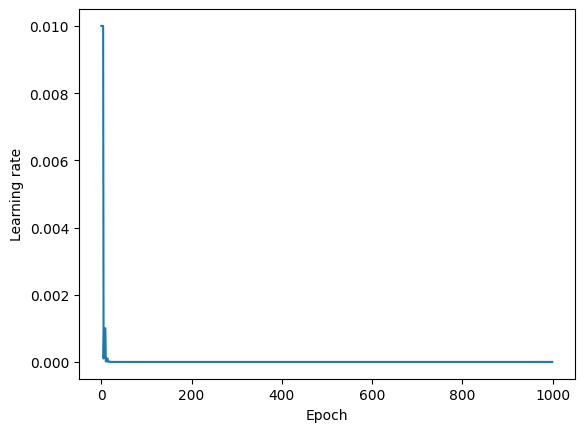

In [119]:
model = NeuralNetwork().to(device)
    
loss_fn = nn.MSELoss()
optimizer = RMSprop(model.parameters())
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

train_loop(model, loss_fn, optimizer, scheduler, num_epochs=1000)